In [1]:
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import tensorflow as tf
import numpy as np
import gymnasium as gym
import keras
import matplotlib.pyplot as plt

In [2]:
class Transition:
    def __init__(self, state, action, reward, next_state, terminated):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
        self.terminated = terminated
        
        self.data = [self.state, self.action, self.reward, self.next_state, self.terminated]
        
    def __repr__(self):
        return f"Transition{self.data}"
    
    def __iter__(self):
        return iter(self.data)
    
    def __getitem__(self, item):
         return self.data[item]

In [3]:
class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def store(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        return batch

In [4]:
class Agent:
    def __init__(self, policy, memory,n_episodes, batch_size, update_frequency, env, tau, gamma):

        self.policy = policy
        self.memory = memory
        self.n_episodes = n_episodes
        self.batch_size = batch_size
        self.update_frequency = update_frequency
        self.env = env
        self.tau = tau
        self.gamma = gamma


    def select_action(self, state):
        return self.policy.select_action(state)
        
    def train(self, batch_size):
        
        # zorg ervoor dat we niet crashen omdat er niet genoeg Transitions in de memory zitten!
        if batch_size > len(self.memory.memory):
            return
        
        batch = self.memory.sample(batch_size)
                        
        states = np.array([transition[0] for transition in batch])
        actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])
        next_states = np.array([transition[3] for transition in batch])
        dones = np.array([transition[4] for transition in batch])
        
        
        # ik itereerde eerst over elke transition in de batch heen maar het gebruik maken van numpy vectors is veel sneller.
        targets = self.policy.model.predict(states, verbose = 0)
        next_actions = np.argmax(self.policy.model.predict(next_states, verbose = 0), axis=1)
        next_q_values = self.policy.target_model.predict(next_states, verbose = 0)
        
        # de *(1-dones) op het eind is een mask die ervoor zorgt dat terminal states niet worden meegenomen
        targets[np.arange(len(batch)), actions] = rewards + self.gamma * next_q_values[np.arange(len(batch)), next_actions] * (1 - dones)
        
        self.policy.model.train_on_batch(states, targets)

    
    def decay(self):
        self.policy.epsilon = max(self.policy.min_epsilon, self.policy.epsilon * self.policy.epsilon_decay_rate)

        
    def align_target_network(self):
        model_weights = self.policy.model.get_weights()
        target_model_weights = self.policy.target_model.get_weights()
        for i in range(len(target_model_weights)):
            target_model_weights[i] = self.tau * model_weights[i] + (1 - self.tau) * target_model_weights[i]
        self.policy.target_model.set_weights(target_model_weights)
        
    def save_model(self, path):
        self.policy.model.save(path)

        
    def load_model(self, path):
        new_model = keras.models.load_model(path)
        new_model_weights = new_model.get_weights()
        self.policy.model.set_weights(new_model_weights)
        self.policy.target_model.set_weights(new_model_weights)
        
    def run(self, train = False, verbose = True):
        
        self.rewards = []
        steps = 0
        for episode in range(self.n_episodes):
            ep_rewards = []
            state, info = self.env.reset()
            while True:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                ep_rewards.append(reward)
                self.memory.store(Transition(state, action, reward, next_state, terminated))
                state = next_state
                
                # update het netwerk elke n stappen als train aan staat
                if steps % self.update_frequency == 0 and train:
                    self.train(self.batch_size)
                    self.align_target_network()
                steps += 1

                if terminated or truncated:
                    break
                    
            self.rewards.append(sum(ep_rewards))
            self.decay()
            
            
            # code om live de performance van het netwerk te kunnen tracken 
            if verbose:
                print(f"\repisode: {episode} | reward: {sum(ep_rewards)} | epsilon {self.policy.epsilon}", end = "")

                if (episode +1) % 25 == 0:
                    window_size = 10
                    averages = [np.mean(self.rewards[i:i+window_size]) for i in range(0, len(self.rewards), window_size)]

                    plt.plot([i * window_size for i in range(len(averages))], averages)
                    plt.xlabel("episode")
                    plt.ylabel("reward")
                    plt.show()



In [5]:
class EpsilonGreedyPolicy:
    
    def __init__(self,epsilon, epsilon_decay_rate, state_size, action_size, alpha, min_epsilon):
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.alpha = alpha
        self.state_size = state_size
        self.action_size = action_size
        self.min_epsilon = min_epsilon
        
        self.model = self.build_model()
        self.target_model = self.build_model()
        
    def select_action(self, state):
        if random.random() < self.epsilon:
            action = random.randint(0, self.action_size - 1)
        else:
            reshaped_state = state.reshape(1, -1)
            action = np.argmax(self.model.predict(reshaped_state, verbose = 0)[0])
        return action
    
    def build_model(self):
        
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='huber', optimizer=Adam(learning_rate=self.alpha))
    
        return model

In [16]:
env = gym.make("LunarLander-v2", render_mode="human")

In [17]:
DDQN = Agent(policy = EpsilonGreedyPolicy(alpha = 0.0005, epsilon = 0.07, epsilon_decay_rate = 0.996, min_epsilon = 0.01, state_size = 8, action_size = 4),
             tau = 0.01, gamma = 0.99,memory = Memory(capacity = 100000), n_episodes = 700, batch_size = 64, update_frequency = 4, env = env)

In [18]:
DDQN.run(train = True, verbose = 1)

episode: 27 | reward: -133.5550882017516 | epsilon 0.062569043493964755

KeyboardInterrupt: 

In [ ]:
#DDQN.load_model("model")

In [14]:
DDQN.save_model("model_v4")

INFO:tensorflow:Assets written to: model_v4\assets


In [19]:
DDQN.load_model("model_v4")

In [20]:
DDQN.policy.epsilon = 0

In [21]:
env = gym.make("LunarLander-v2", render_mode="human")
DDQN.env = env

episode: 49 | reward: 242.38754908109232 | epsilon 0.01

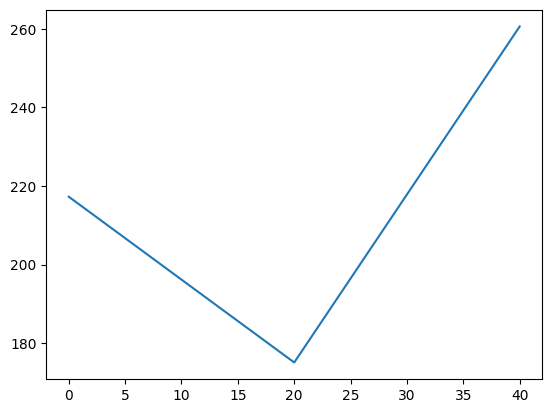

episode: 99 | reward: 248.64635946555555 | epsilon 0.01

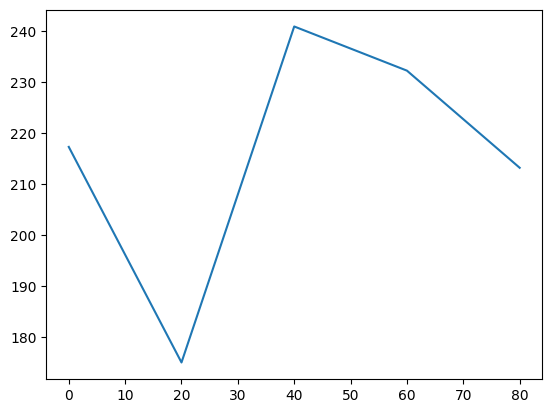

episode: 149 | reward: 279.81746839566506 | epsilon 0.011

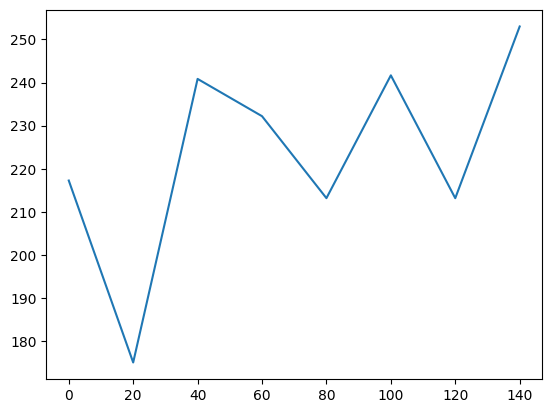

episode: 199 | reward: 279.589452460927 | epsilon 0.0111

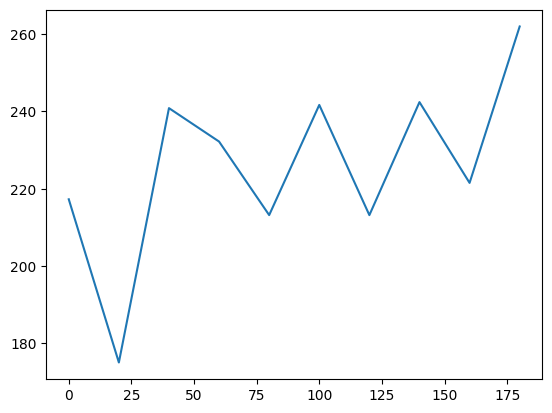

episode: 249 | reward: 310.5184470646809 | epsilon 0.011

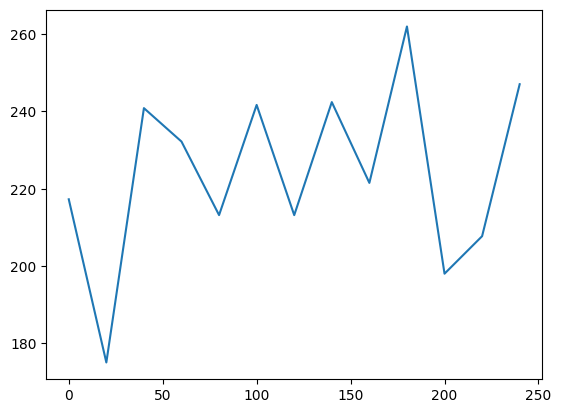

episode: 299 | reward: 254.2525592732222 | epsilon 0.0111

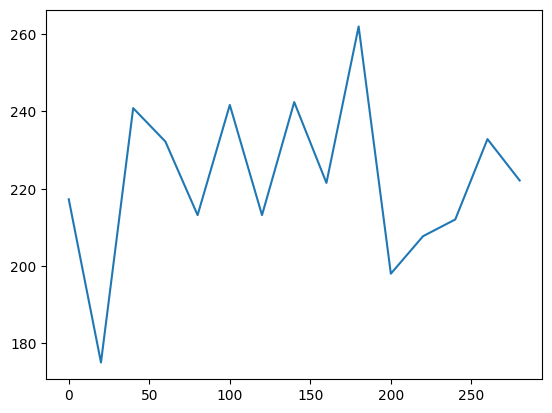

episode: 349 | reward: 198.4880633394402 | epsilon 0.0111

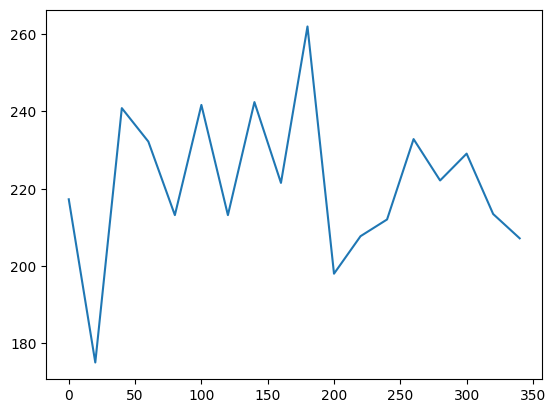

episode: 399 | reward: 271.7941499745241 | epsilon 0.0111

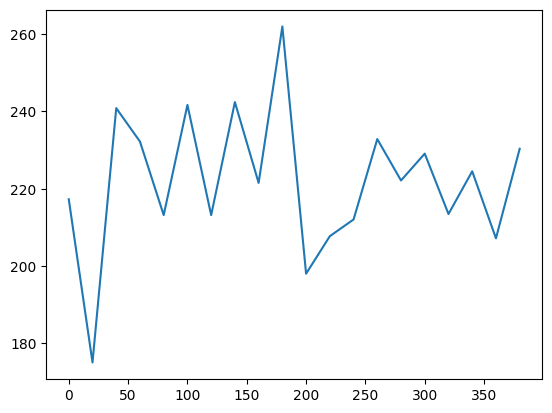

episode: 449 | reward: 24.270208044776794 | epsilon 0.011

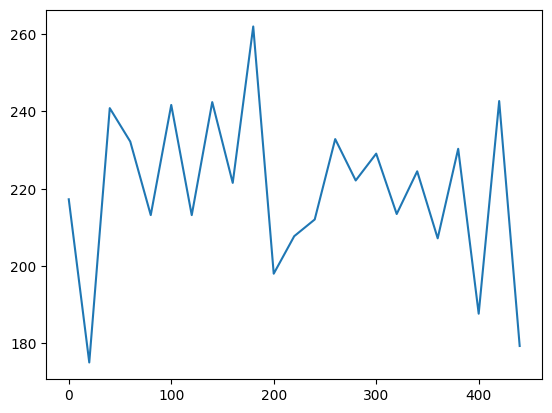

episode: 499 | reward: 299.13036700481314 | epsilon 0.01

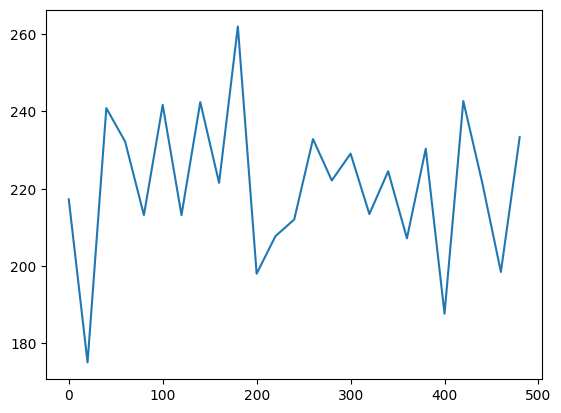

episode: 509 | reward: 273.68294919724735 | epsilon 0.01

KeyboardInterrupt: 

In [22]:
DDQN.run(train = False, verbose = True)

In [24]:
np.mean(DDQN.rewards)

221.61545925344834